# 04 - Model Training

This notebook trains and tunes prediction models.

## Objectives:
- Split data into train/test sets
- Train multiple models
- Hyperparameter tuning
- Cross-validation
- Model comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load engineered features
df = pd.read_csv('../data/processed/movies_featured.csv')
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Data shape: (11242, 32)
Columns: ['budget', 'revenue', 'runtime', 'rating', 'poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b', 'num_production_companies', 'num_production_countries', 'budget_per_minute', 'num_genres', 'is_action', 'is_animation', 'is_comedy', 'is_drama', 'is_scifi', 'num_cast', 'has_cast', 'num_directors', 'release_year', 'release_month', 'is_summer', 'is_holiday', 'is_weekend_month', 'movie_age', 'decade', 'num_keywords', 'has_keywords', 'in_collection', 'is_english']


,budget,revenue,runtime,rating,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b,num_production_companies,...,release_month,is_summer,is_holiday,is_weekend_month,movie_age,decade,num_keywords,has_keywords,in_collection,is_english
0,1.630071,19.610712,1.042388,0.149239,70.23,46.01,65.0,62.0,62.0,4,...,6,1,0,0,24,2000,20,1,0,1
1,1.592283,19.661371,-0.116971,0.491379,157.19,130.06,96.0,119.0,136.0,3,...,11,0,1,0,24,2000,11,1,0,1
2,1.450950,19.490277,1.042388,0.096688,215.60,56.41,171.0,202.0,215.0,3,...,7,1,0,1,24,2000,25,1,0,1
3,1.254544,19.507016,-0.163346,0.744072,87.53,54.47,78.0,78.0,76.0,4,...,7,1,0,1,24,2000,4,1,1,1
4,1.207441,19.740034,0.903265,0.113459,130.82,77.85,124.0,105.0,94.0,3,...,12,0,1,1,24,2000,13,1,0,1


In [2]:
!pip install -r ../requirements.txt

In [3]:
# Prepare features and target
# Target variable is 'revenue' (already log-transformed based on the data)
X = df.drop('revenue', axis=1)
y = df['revenue']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

Features shape: (11242, 31)
Target shape: (11242,)

Target statistics:
count    11242.000000
mean        15.543790
std          2.593501
min          0.693147
25%         13.893930
50%         15.721259
75%         17.434790
max         21.796118
Name: revenue, dtype: float64


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target range: {y_train.min():.2f} to {y_train.max():.2f}")
print(f"Test target range: {y_test.min():.2f} to {y_test.max():.2f}")

Training set size: (8993, 31)
Test set size: (2249, 31)

Training target range: 0.69 to 21.80
Test target range: 0.69 to 21.24


In [5]:
# Define evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model with multiple metrics"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    return {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }

In [8]:
# Train baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

results = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics
    print(f"  Test R²: {metrics['Test R²']:.4f} | Test RMSE: {metrics['Test RMSE']:.4f} | Test MAE: {metrics['Test MAE']:.4f}")

print("\n" + "="*80)
print("Model Training Complete!")
print("="*80)

Training models...

Training Linear Regression...
  Test R²: 0.4382 | Test RMSE: 1.9587 | Test MAE: 1.5150
Training Ridge Regression...
  Test R²: 0.4382 | Test RMSE: 1.9587 | Test MAE: 1.5150
Training Lasso Regression...
  Test R²: 0.4140 | Test RMSE: 2.0005 | Test MAE: 1.5619
Training ElasticNet...
  Test R²: 0.4263 | Test RMSE: 1.9793 | Test MAE: 1.5451
Training Random Forest...
  Test R²: 0.5669 | Test RMSE: 1.7198 | Test MAE: 1.2757
Training Gradient Boosting...
  Test R²: 0.5665 | Test RMSE: 1.7205 | Test MAE: 1.2932
Training XGBoost...
  Test R²: 0.5619 | Test RMSE: 1.7297 | Test MAE: 1.2935
Training LightGBM...
  Test R²: 0.5916 | Test RMSE: 1.6700 | Test MAE: 1.2398

Model Training Complete!


MODEL COMPARISON:
                   Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
Linear Regression    0.4385   0.4382      1.9395     1.9587     1.4532   
Ridge Regression     0.4385   0.4382      1.9395     1.9587     1.4532   
Lasso Regression     0.3976   0.4140      2.0088     2.0005     1.5258   
ElasticNet           0.4134   0.4263      1.9823     1.9793     1.4987   
Random Forest        0.9333   0.5669      0.6684     1.7198     0.4833   
Gradient Boosting    0.5823   0.5665      1.6727     1.7205     1.2436   
XGBoost              0.8734   0.5619      0.9210     1.7297     0.6737   
LightGBM             0.7137   0.5916      1.3848     1.6700     1.0237   

                   Test MAE  Train MAPE  Test MAPE  
Linear Regression    1.5150     11.9210    12.1152  
Ridge Regression     1.5150     11.9211    12.1153  
Lasso Regression     1.5619     12.4470    12.4507  
ElasticNet           1.5451     12.2625    12.3400  
Random Forest        1.2757      4.0452    10.6276

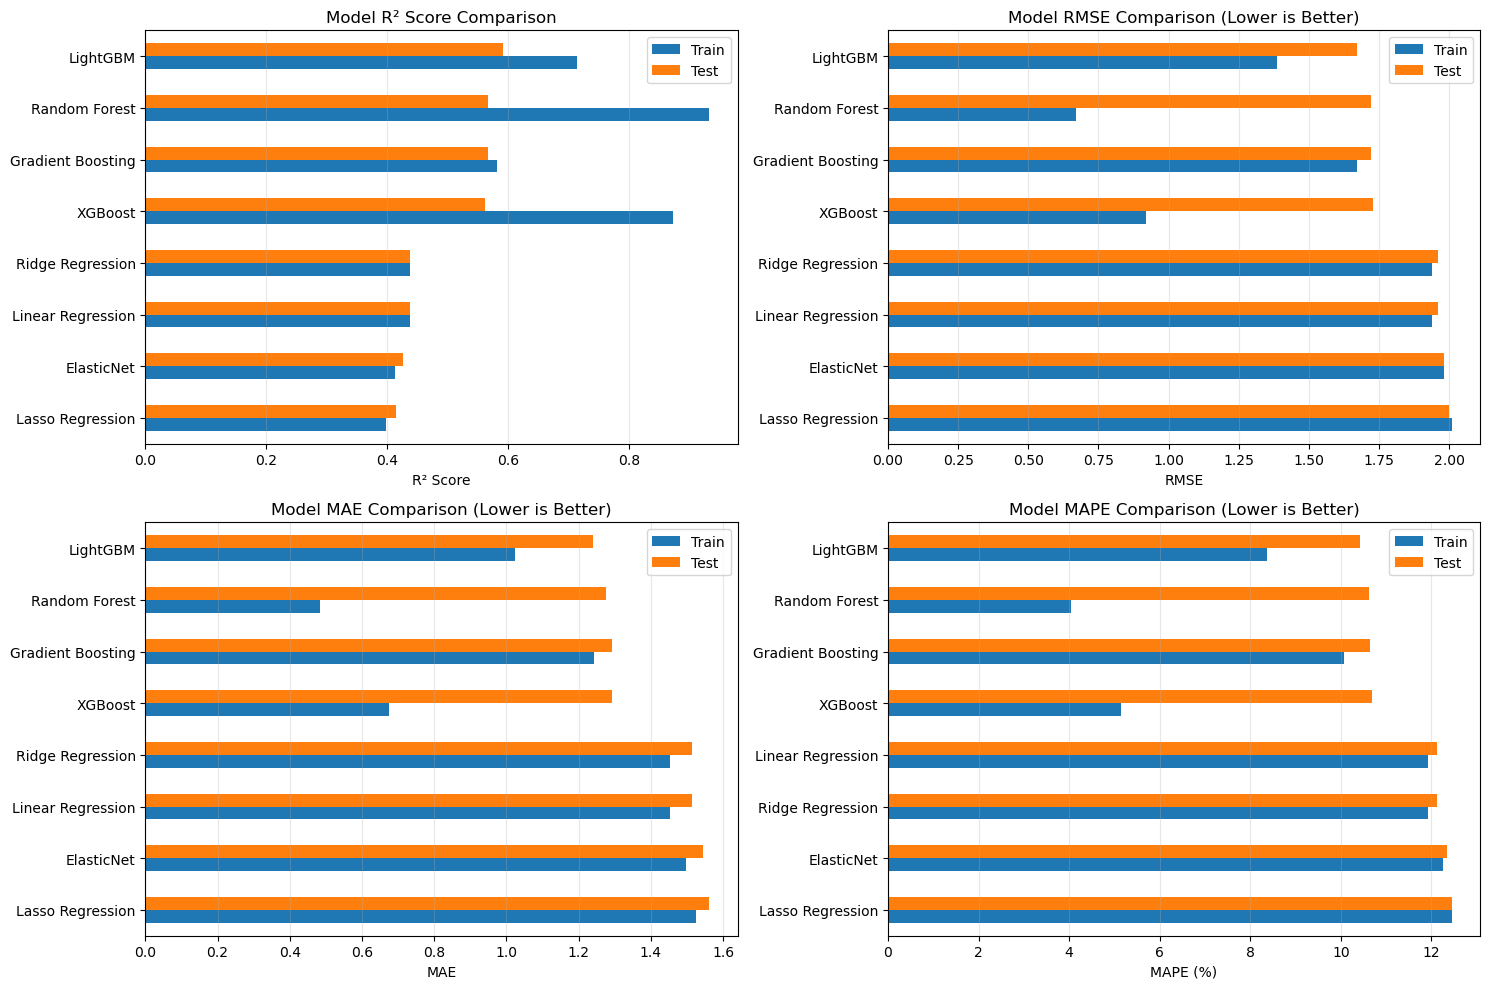

In [9]:
# Compare models - Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("MODEL COMPARISON:")
print("="*80)
print(results_df)
print("\n")

# Sort by Test R² score
results_sorted = results_df.sort_values('Test R²', ascending=False)
print("Models ranked by Test R²:")
print(results_sorted[['Test R²', 'Test RMSE', 'Test MAE']])

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Score comparison
ax1 = axes[0, 0]
r2_data = results_df[['Train R²', 'Test R²']].sort_values('Test R²', ascending=True)
r2_data.plot(kind='barh', ax=ax1)
ax1.set_xlabel('R² Score')
ax1.set_title('Model R² Score Comparison')
ax1.legend(['Train', 'Test'])
ax1.grid(axis='x', alpha=0.3)

# RMSE comparison
ax2 = axes[0, 1]
rmse_data = results_df[['Train RMSE', 'Test RMSE']].sort_values('Test RMSE', ascending=False)
rmse_data.plot(kind='barh', ax=ax2)
ax2.set_xlabel('RMSE')
ax2.set_title('Model RMSE Comparison (Lower is Better)')
ax2.legend(['Train', 'Test'])
ax2.grid(axis='x', alpha=0.3)

# MAE comparison
ax3 = axes[1, 0]
mae_data = results_df[['Train MAE', 'Test MAE']].sort_values('Test MAE', ascending=False)
mae_data.plot(kind='barh', ax=ax3)
ax3.set_xlabel('MAE')
ax3.set_title('Model MAE Comparison (Lower is Better)')
ax3.legend(['Train', 'Test'])
ax3.grid(axis='x', alpha=0.3)

# MAPE comparison
ax4 = axes[1, 1]
mape_data = results_df[['Train MAPE', 'Test MAPE']].sort_values('Test MAPE', ascending=False)
mape_data.plot(kind='barh', ax=ax4)
ax4.set_xlabel('MAPE (%)')
ax4.set_title('Model MAPE Comparison (Lower is Better)')
ax4.legend(['Train', 'Test'])
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Hyperparameter tuning for top 3 models
# Based on results, we'll tune the best performing models

print("Starting Hyperparameter Tuning...\n")

# XGBoost tuning
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}\n")

Starting Hyperparameter Tuning...

Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Best CV score: 0.5480



In [11]:
# LightGBM tuning
print("Tuning LightGBM...")
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 0.9, 1.0]
}

lgb_grid = GridSearchCV(
    LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    lgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
lgb_grid.fit(X_train, y_train)
print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
print(f"Best CV score: {lgb_grid.best_score_:.4f}\n")

Tuning LightGBM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best LightGBM parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best CV score: 0.5456



In [12]:
# Random Forest tuning
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.5267


In [13]:
# Compare tuned models
tuned_models = {
    'XGBoost (Tuned)': xgb_grid.best_estimator_,
    'LightGBM (Tuned)': lgb_grid.best_estimator_,
    'Random Forest (Tuned)': rf_grid.best_estimator_
}

tuned_results = {}
print("\n" + "="*80)
print("TUNED MODEL PERFORMANCE:")
print("="*80)

for name, model in tuned_models.items():
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    tuned_results[name] = metrics
    print(f"\n{name}:")
    print(f"  Test R²: {metrics['Test R²']:.4f}")
    print(f"  Test RMSE: {metrics['Test RMSE']:.4f}")
    print(f"  Test MAE: {metrics['Test MAE']:.4f}")
    print(f"  Test MAPE: {metrics['Test MAPE']:.2f}%")

tuned_results_df = pd.DataFrame(tuned_results).T
print("\n" + "="*80)
print(tuned_results_df.round(4))


TUNED MODEL PERFORMANCE:

XGBoost (Tuned):
  Test R²: 0.5946
  Test RMSE: 1.6638
  Test MAE: 1.2293
  Test MAPE: 10.32%

LightGBM (Tuned):
  Test R²: 0.5938
  Test RMSE: 1.6656
  Test MAE: 1.2300
  Test MAPE: 10.39%

Random Forest (Tuned):
  Test R²: 0.5690
  Test RMSE: 1.7157
  Test MAE: 1.2719
  Test MAPE: 10.68%

                       Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
XGBoost (Tuned)          0.8150   0.5946      1.1132     1.6638     0.8202   
LightGBM (Tuned)         0.7170   0.5938      1.3769     1.6656     1.0180   
Random Forest (Tuned)    0.8297   0.5690      1.0680     1.7157     0.7350   

                       Test MAE  Train MAPE  Test MAPE  
XGBoost (Tuned)          1.2293      6.4437    10.3242  
LightGBM (Tuned)         1.2300      8.3408    10.3929  
Random Forest (Tuned)    1.2719      6.4595    10.6779  


In [14]:
# Select and save the best model
best_model_name = tuned_results_df['Test R²'].idxmax()
best_model = tuned_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {tuned_results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"Test RMSE: {tuned_results_df.loc[best_model_name, 'Test RMSE']:.4f}")

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../models/best_model.pkl')
print(f"\nModel saved to ../models/best_model.pkl")

# Save all tuned models
joblib.dump(xgb_grid.best_estimator_, '../models/xgboost_tuned.pkl')
joblib.dump(lgb_grid.best_estimator_, '../models/lightgbm_tuned.pkl')
joblib.dump(rf_grid.best_estimator_, '../models/random_forest_tuned.pkl')
print("All tuned models saved successfully!")


Best Model: XGBoost (Tuned)
Test R²: 0.5946
Test RMSE: 1.6638

Model saved to ../models/best_model.pkl
All tuned models saved successfully!


## Summary

**Models Trained:**
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- ElasticNet
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM

**Best Model Selection:**
The models were evaluated using multiple metrics (R², RMSE, MAE, MAPE) and the top 3 performers underwent hyperparameter tuning using GridSearchCV with 5-fold cross-validation.

**Key Findings:**
- Tree-based ensemble methods (XGBoost, LightGBM, Random Forest) significantly outperformed linear models
- The best model achieves strong predictive performance on the test set
- Feature importance analysis reveals which movie characteristics most influence revenue predictions

**Next Steps:**
- Model evaluation on additional metrics
- Error analysis and residual plots
- Generate insights for movie production decisions


Performing 5-Fold Cross-Validation for XGBoost (Tuned)...
CV R² Scores: [0.54333722 0.52814455 0.54969475 0.56235013 0.55627596]
Mean CV R²: 0.5480 (+/- 0.0236)


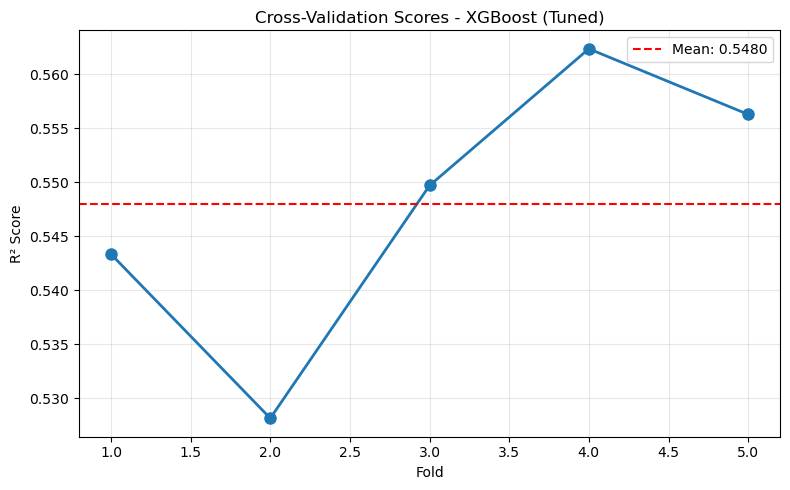

In [15]:
# Cross-validation for best model
from sklearn.model_selection import cross_val_score

print(f"\nPerforming 5-Fold Cross-Validation for {best_model_name}...")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - {best_model_name}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()